# UFC Match Predictor (XGBoost & NN)

## 1. Imports

First, we import all the necessary libraries. 

- `pandas`: For data manipulation and loading the CSV.
- `xgboost`: To use the XGBClassifier, our machine learning model.
- `matplotlib`: For plotting our evaluation metrics.
- `%matplotlib inline`: A Jupyter magic command to make plots appear directly in the notebook.
- `sklearn`: We use scikit-learn for:
    - `SimpleImputer`: To handle missing (NaN) values.
    - `train_test_split`: To create training and testing datasets.
    - `KFold` & `cross_val_score`: To perform robust model evaluation.
    - `accuracy_score`, `confusion_matrix`, `log_loss`: For scoring our model.

In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss

# Setting to display all columns in pandas DataFrames
pd.set_option('display.max_columns', None)

## 2. Data Exploration (EDA)

We load the dataset and perform an initial Exploratory Data Analysis (EDA) to understand its structure.

In [2]:
print("--- Start Chapter 1: Data Exploration ---")
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('data/large_dataset.csv')

# Display the first 5 rows
print("First 5 rows of the dataset:")
df.head()

--- Start Chapter 1: Data Exploration ---
First 5 rows of the dataset:


,event_name,r_fighter,b_fighter,winner,weight_class,is_title_bout,gender,method,finish_round,total_rounds,time_sec,referee,r_kd,r_sig_str,r_sig_str_att,r_sig_str_acc,r_str,r_str_att,r_str_acc,r_td,r_td_att,r_td_acc,r_sub_att,r_rev,r_ctrl_sec,r_wins_total,r_losses_total,r_age,r_height,r_weight,r_reach,r_stance,r_SLpM_total,r_SApM_total,r_sig_str_acc_total,r_td_acc_total,r_str_def_total,r_td_def_total,r_sub_avg,r_td_avg,b_kd,b_sig_str,b_sig_str_att,b_sig_str_acc,b_str,b_str_att,b_str_acc,b_td,b_td_att,b_td_acc,b_sub_att,b_rev,b_ctrl_sec,b_wins_total,b_losses_total,b_age,b_height,b_weight,b_reach,b_stance,b_SLpM_total,b_SApM_total,b_sig_str_acc_total,b_td_acc_total,b_str_def_total,b_td_def_total,b_sub_avg,b_td_avg,kd_diff,sig_str_diff,sig_str_att_diff,sig_str_acc_diff,str_diff,str_att_diff,str_acc_diff,td_diff,td_att_diff,td_acc_diff,sub_att_diff,rev_diff,ctrl_sec_diff,wins_total_diff,losses_total_diff,age_diff,height_diff,weight_diff,reach_diff,SLpM_total_diff,SApM_total_diff,sig_str_acc_total_diff,td_acc_total_diff,str_def_total_diff,td_def_total_diff,sub_avg_diff,td_avg_diff
0,UFC Fight Night: Ribas vs. Namajunas,Amanda Ribas,Rose Namajunas,Blue,Women's Flyweight,0,Women,Decision - Unanimous,5,5.0,300,Jason Herzog,0,83,270,0.30,137,342,0.40,4,8,0.50,0,0,98,12,5,30.0,160.02,56.70,167.64,Orthodox,4.63,3.40,0.40,0.51,0.61,0.85,0.7,2.07,0,93,188,0.49,169,281,0.60,1,3,0.33,0,1,419,13,6,31.0,165.10,56.70,165.10,Orthodox,3.69,3.51,0.41,0.47,0.63,0.59,0.5,1.38,0,-10,82,-0.19,-32,61,-0.20,3,5,0.17,0,-1,-321,-1,-1,-1.0,-5.08,0.00,2.54,0.94,-0.11,-0.01,0.04,-0.02,0.26,0.2,0.69
1,UFC Fight Night: Ribas vs. Namajunas,Karl Williams,Justin Tafa,Red,Heavyweight,0,Men,Decision - Unanimous,3,3.0,300,Herb Dean,0,40,61,0.65,123,176,0.70,7,12,0.58,1,0,631,10,1,34.0,190.50,106.59,200.66,Orthodox,2.87,1.70,0.52,0.50,0.60,1.00,0.2,4.75,0,21,43,0.48,27,50,0.54,0,0,0.00,0,0,0,7,4,30.0,182.88,119.75,187.96,Southpaw,4.09,5.02,0.54,0.00,0.47,0.50,0.0,0.00,0,19,18,0.17,96,126,0.16,7,12,0.58,1,0,631,3,-3,4.0,7.62,-13.16,12.70,-1.22,-3.32,-0.02,0.50,0.13,0.50,0.2,4.75
2,UFC Fight Night: Ribas vs. Namajunas,Edmen Shahbazyan,AJ Dobson,Red,Middleweight,0,Men,KO/TKO,1,3.0,273,Mark Smith,1,27,43,0.62,31,51,0.61,1,3,0.33,0,0,49,13,4,26.0,187.96,83.91,190.50,Orthodox,3.60,4.09,0.52,0.38,0.45,0.63,0.6,2.24,0,15,46,0.32,20,54,0.37,0,0,0.00,0,1,75,7,3,32.0,185.42,83.91,193.04,Orthodox,4.29,5.31,0.46,0.75,0.46,0.65,0.3,1.67,1,12,-3,0.30,11,-3,0.24,1,3,0.33,0,-1,-26,6,1,-6.0,2.54,0.00,-2.54,-0.69,-1.22,0.06,-0.37,-0.01,-0.02,0.3,0.57
3,UFC Fight Night: Ribas vs. Namajunas,Payton Talbott,Cameron Saaiman,Red,Bantamweight,0,Men,KO/TKO,2,3.0,21,Chris Tognoni,1,79,129,0.61,83,135,0.61,0,1,0.00,0,0,30,8,0,25.0,177.80,61.23,177.80,Switch,8.05,3.58,0.54,0.00,0.51,0.90,0.5,0.00,0,31,64,0.48,33,66,0.50,0,3,0.00,0,0,0,9,2,23.0,172.72,61.23,170.18,Southpaw,5.32,4.18,0.46,0.28,0.51,0.47,0.7,0.91,1,48,65,0.13,50,69,0.11,0,-2,0.00,0,0,30,-1,-2,2.0,5.08,0.00,7.62,2.73,-0.60,0.08,-0.28,0.00,0.43,-0.2,-0.91
4,UFC Fight Night: Ribas vs. Namajunas,Billy Quarantillo,Youssef Zalal,Blue,Featherweight,0,Men,Submission,2,3.0,110,Herb Dean,0,10,50,0.20,26,74,0.35,0,0,0.00,0,0,21,18,6,35.0,177.80,65.77,177.80,Orthodox,7.36,5.57,0.56,0.23,0.43,0.61,1.1,1.24,0,33,56,0.58,37,62,0.60,2,2,1.00,2,0,175,14,5,27.0,177.80,65.77,182.88,Switch,2.88,1.73,0.49,0.34,0.65,0.60,1.3,2.28,0,-23,-6,-0.38,-11,12,-0.25,-2,-2,-1.00,-2,0,-154,4,1,8.0,0.00,0.00,-5.08,4.48,3.84,0.07,-0.11,-0.22,0.01,-0.2,-1.04


### Technical Summary

We use `.info()` to get a technical summary, showing data types (like `float64`, `object`) and the count of non-null values for each column.

In [3]:
print("\nTechnical information about the dataset:")
df.info()


Technical information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7439 entries, 0 to 7438
Data columns (total 95 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_name              7439 non-null   object 
 1   r_fighter               7439 non-null   object 
 2   b_fighter               7439 non-null   object 
 3   winner                  7439 non-null   object 
 4   weight_class            7439 non-null   object 
 5   is_title_bout           7439 non-null   int64  
 6   gender                  7439 non-null   object 
 7   method                  7439 non-null   object 
 8   finish_round            7439 non-null   int64  
 9   total_rounds            7408 non-null   float64
 10  time_sec                7439 non-null   int64  
 11  referee                 7407 non-null   object 
 12  r_kd                    7439 non-null   int64  
 13  r_sig_str               7439 non-null   int64  
 14

### Statistical Summary

We use `.describe()` to get a statistical summary (like mean, median, min, max) for all numerical columns.

In [4]:
print("\nStatistical summary of the dataset:")
df.describe()


Statistical summary of the dataset:


,is_title_bout,finish_round,total_rounds,time_sec,r_kd,r_sig_str,r_sig_str_att,r_sig_str_acc,r_str,r_str_att,r_str_acc,r_td,r_td_att,r_td_acc,r_sub_att,r_rev,r_ctrl_sec,r_wins_total,r_losses_total,r_age,r_height,r_weight,r_reach,r_SLpM_total,r_SApM_total,r_sig_str_acc_total,r_td_acc_total,r_str_def_total,r_td_def_total,r_sub_avg,r_td_avg,b_kd,b_sig_str,b_sig_str_att,b_sig_str_acc,b_str,b_str_att,b_str_acc,b_td,b_td_att,b_td_acc,b_sub_att,b_rev,b_ctrl_sec,b_wins_total,b_losses_total,b_age,b_height,b_weight,b_reach,b_SLpM_total,b_SApM_total,b_sig_str_acc_total,b_td_acc_total,b_str_def_total,b_td_def_total,b_sub_avg,b_td_avg,kd_diff,sig_str_diff,sig_str_att_diff,sig_str_acc_diff,str_diff,str_att_diff,str_acc_diff,td_diff,td_att_diff,td_acc_diff,sub_att_diff,rev_diff,ctrl_sec_diff,wins_total_diff,losses_total_diff,age_diff,height_diff,weight_diff,reach_diff,SLpM_total_diff,SApM_total_diff,sig_str_acc_total_diff,td_acc_total_diff,str_def_total_diff,td_def_total_diff,sub_avg_diff,td_avg_diff
count,7439.000000,7439.000000,7408.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7363.000000,7439.000000,7439.000000,7027.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7249.000000,7439.000000,7439.000000,6551.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.00000,7439.000000,7226.000000,7439.000000,7439.000000,6401.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000,7439.000000
mean,0.055787,2.336336,3.128915,227.016669,0.249227,38.361204,83.786262,0.475335,58.199892,106.374916,0.555443,1.226509,2.940852,0.311075,0.455706,0.134427,152.120850,19.187928,7.940315,38.316855,178.620831,76.488396,183.212546,3.411758,3.282863,0.441424,0.388321,0.543109,0.602820,0.645194,1.598066,0.181342,33.499933,78.222476,0.429845,49.416992,96.382309,0.515155,0.892996,2.652507,0.226211,0.325447,0.133082,109.204732,17.169109,7.399113,37.718996,178.574736,76.317396,182.819127,3.269164,3.454506,0.429314,0.360157,0.522201,0.565307,0.599543,1.463578,0.067885,4.861272,5.563785,0.045490,8.782901,9.992607,0.040288,0.333513,0.288345,0.084865,0.130259,0.001344,42.916118,2.01882,0.541202,0.388043,0.046095,0.171000,0.190073,0.142594,-0.171643,0.012109,0.028164,0.020909,0.037513,0.045651,0.134487
std,0.229525,1.015243,0.652739,98.169665,0.524210,32.871278,71.381806,0.165935,46.057503,79.812210,0.176402,1.819250,3.710736,0.372214,0.897335,0.427222,192.097306,9.474207,4.641395,6.426288,8.969921,16.428678,10.842633,1.332992,1.222434,0.092338,0.186749,0.097713,0.205218,0.757643,1.272004,0.455962,30.759088,68.828665,0.174063,41.376059,76.205423,0.186202,1.521771,3.704621,0.334190,0.765368,0.413578,151.635875,9.235377,4.471024,6.415852,8.885385,16.700749,10.660761,1.451367,1.549403,0.110161,0.213430,0.116185,0.239035,0.807908,1.310877,0.731381,26.498537,42.933081,0.240379,45.842688,61.554186,0.229646,2.509234,5.508415,0.524888,1.154435,0.482552,248.351021,11.60913,5.727700,5.223528,6.497921,6.774199,8.252628,1.585610,1.691358,0.119919,0.276307,0.113455,0.292107,1.052065,1.781598
min,0.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,152.400000,52.160000,147.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

### Target Variable Distribution

We check the distribution of our target variable, `winner`. This is important to see if our dataset is balanced or imbalanced. An imbalanced dataset (e.g., 90% Red wins, 10% Blue wins) would require special handling.

In [5]:
print("\nUnique values in the 'winner' column:")
df['winner'].value_counts()


Unique values in the 'winner' column:


winner
Red     4876
Blue    2563
Name: count, dtype: int64

## 3. Data Cleaning & Preprocessing

Now we clean the data and prepare it for the machine learning model.

### Target Encoding

Our target variable `winner` is text ('Red', 'Blue'). Machine learning models require numerical input. We will convert 'Red' to `1` and 'Blue' to `0`.

In [6]:
print("\n--- Start Chapter 2: Data Cleaning & Preprocessing ---")
print("\n'winner' column converting to numerical (1 for Red, 0 for Blue)...")
df['winner'] = df['winner'].replace({'Red': 1, 'Blue': 0})
print("Conversion complete.")


--- Start Chapter 2: Data Cleaning & Preprocessing ---

'winner' column converting to numerical (1 for Red, 0 for Blue)...
Conversion complete.


C:\Users\ebube\AppData\Local\Temp\ipykernel_7512\1926607315.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'Red': 1, 'Blue': 0})


### Splitting Features (X) and Target (y)

We separate our dataset into two parts:
- `y` (the target): The single column we want to predict (`winner`).
- `X` (the features): All the other columns we will use to make the prediction.

In [7]:
print("\nSeparating data into X (features) and y (target)...")
# 'y' is the column we want to predict
y = df['winner']
# 'X' is everything else
X = df.drop(columns=['winner'])
print("Separation complete.")


Separating data into X (features) and y (target)...
Separation complete.


### Feature Dropping

We remove columns from `X` that are not useful for prediction. These include:
- **Data Leakage:** Columns that would "cheat" (e.g., `finish_round`, `method`). These are results of the fight, which we wouldn't know beforehand.
- **Per-Minute Stats:** We drop the raw count stats (e.g., `r_sig_str`) and keep the *per-minute* averages (which are already in the dataset, e.g., `r_avg_sig_str_pm`).
- **Identifiers:** Text-based IDs like `event_name`, `r_fighter`, and `referee` are not numerical features.

In [8]:
print("\nCleaning X (features)...")
columns_to_drop_from_X = [
    'r_kd', 'r_sig_str', 'r_sig_str_att', 'r_sig_str_acc', 'r_str', 'r_str_att', 'r_str_acc',
    'r_td', 'r_td_att', 'r_td_acc', 'r_sub_att', 'r_rev', 'r_ctrl_sec',
    'b_kd', 'b_sig_str', 'b_sig_str_att', 'b_sig_str_acc', 'b_str', 'b_str_att', 'b_str_acc',
    'b_td', 'b_td_att', 'b_td_acc', 'b_sub_att', 'b_rev', 'b_ctrl_sec',
    'finish_round', 'time_sec', 'method',
    'event_name', 'r_fighter', 'b_fighter', 'weight_class', 'gender', 'referee', 'r_stance', 'b_stance'
]
X_clean = X.drop(columns=columns_to_drop_from_X)
print(f"{len(columns_to_drop_from_X)} columns removed from X.")


Cleaning X (features)...
37 columns removed from X.


### Handling Missing Values (Imputation)

Some columns might have missing values (NaN). XGBoost can sometimes handle this, but it's cleaner to fill them. We use `SimpleImputer` from scikit-learn to fill all missing values with the `mean` (average) of their respective column.

In [9]:
print("\n--- Start Chapter 3: Filling Missing Values ---")
imputer = SimpleImputer(strategy='mean')
X_final = pd.DataFrame(imputer.fit_transform(X_clean), columns=X_clean.columns)
print("Missing values filled.")


--- Start Chapter 3: Filling Missing Values ---
Missing values filled.


## 4. Model Evaluation & Training

This is where we test our model. We will first get a robust accuracy score using Cross-Validation, and then train a final model to see which features are most important.

### Phase 1: Cross-Validation

Instead of a simple train/test split, we use 5-Fold Cross-Validation. This splits the data into 5 parts ("folds"). It trains the model 5 times, each time using a different fold as the test set and the other 4 as the training set.

This gives a much more reliable estimate of our model's true accuracy on new, unseen data.

In [10]:
print("\n--- Start Chapter 5: Evaluation & Final Training ---")

# We initialize our model (the 'blueprint')
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# --- Phase 1: Evaluate with Cross-Validation ---
print("\nPhase 1: Evaluating model performance with 5-Fold Cross-Validation...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_final, y, cv=cv, scoring='accuracy')

print(f"Scores for each of the 5 Folds: {scores}")
print(f"Average Accuracy: {scores.mean() * 100:.2f}%")
print(f"Standard Deviation: {scores.std() * 100:.2f}%")


--- Start Chapter 5: Evaluation & Final Training ---

Phase 1: Evaluating model performance with 5-Fold Cross-Validation...


C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\O

Scores for each of the 5 Folds: [0.88776882 0.89516129 0.88508065 0.89112903 0.89240081]
Average Accuracy: 89.03%
Standard Deviation: 0.35%


### Phase 2: Final Model Training & Feature Importance

Now that we know our model's performance (e.g., +-90% accuracy), we train one final model on 100% of the data. 

We can then inspect this fully-trained model to see which features it found most predictive. This is a key part of machine learning, as it helps us understand *why* the model makes its decisions.

In [12]:
print("\nPhase 2: Training final model on ALL data...")
# We use the same 'model' object, but now train it on 100% of the data
model.fit(X_final, y)
print("Final model trained!")

# Now we can check the feature importances of this final, fully trained model
feature_importances = pd.DataFrame({
    'feature': X_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features according to the final model:")
feature_importances.head(10)


Phase 2: Training final model on ALL data...


C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model trained!

Top 10 Most Important Features according to the final model:


,feature,importance
31,sig_str_diff,0.205078
30,kd_diff,0.080026
40,sub_att_diff,0.066758
34,str_diff,0.057426
42,ctrl_sec_diff,0.040452
1,total_rounds,0.023808
18,b_age,0.023786
37,td_diff,0.020310
44,losses_total_diff,0.015801
43,wins_total_diff,0.015401


## 5. Advanced Evaluation

Accuracy is good, but not the only metric. For advanced metrics like a Confusion Matrix and Log Loss, we need a dedicated `test` set. We will create a standard 80% training / 20% testing split.

### Train/Test Split

We split the data so we can train the model on one part and test it on another.

In [13]:
print("\n--- Start Chapter 6: Advanced Evaluation ---")

# We need a train/test split for the confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


--- Start Chapter 6: Advanced Evaluation ---


### Re-train Model on Training Set

We train the model *only* on the `X_train` data and then make predictions on the unseen `X_test` data.

In [14]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
proba_predictions = model.predict_proba(X_test) # Get the probabilities

C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 1. Confusion Matrix

A confusion matrix shows us *what kinds* of mistakes our model is making. It's much more informative than accuracy alone.

**How to Read This Matrix:**
* **Top-Left (True Negative):** The model predicted 'Blue Wins', and 'Blue' *did* win. (Correct)
* **Bottom-Right (True Positive):** The model predicted 'Red Wins', and 'Red' *did* win. (Correct)
* **Top-Right (False Positive):** The model predicted 'Red Wins', but 'Blue' *actually* won. (Incorrect)
* **Bottom-Left (False Negative):** The model predicted 'Blue Wins', but 'Red' *actually* won. (Incorrect)

By looking at the numbers in the incorrect squares, we can see if our model has a bias (e.g., if it's much worse at predicting Blue wins than Red wins).


Confusion Matrix:
[[433  84]
 [ 83 888]]


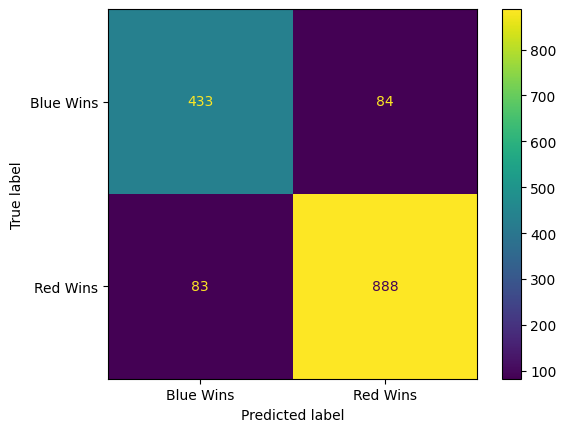

In [16]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions)
print(cm)

# Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blue Wins', 'Red Wins'])
disp.plot()
plt.show()

### 2. Log Loss (on Test Set)

`Log Loss` is a metric that heavily penalizes *confident wrong answers*. 

- If the model says "I am 99% sure Red wins" and Blue wins, it gets a high penalty.
- If it says "I am 51% sure Red wins" and Blue wins, it gets a small penalty.

A lower Log Loss score is better (a perfect score is 0).

In [17]:
logloss_score = log_loss(y_test, proba_predictions)
print(f"\nLog Loss on the test set: {logloss_score:.4f}")


Log Loss on the test set: 0.3048


### 3. Robust Log Loss (with Cross-Validation)

Finally, just as we did with accuracy, we can get a more robust `Log Loss` score by using 5-fold cross-validation. This gives us the best estimate of our model's true confidence and penalty-score.

In [18]:
print("\nCalculating Log Loss with 5-Fold Cross-Validation...")
# We use 'neg_log_loss' because sklearn tries to maximize scores
neg_log_loss_scores = cross_val_score(model, X_final, y, cv=cv, scoring='neg_log_loss')
avg_log_loss = -neg_log_loss_scores.mean()

print(f"Average Cross-Validated Log Loss: {avg_log_loss:.4f}")


Calculating Log Loss with 5-Fold Cross-Validation...


C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\OneDrive\Documenten\SEM 1\Machine Learning\Python_projecten\UFC_Forecaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ebube\O

Average Cross-Validated Log Loss: 0.2966
